In [2]:
import asyncio
import cloudscraper
import json

async def load_games_page(scraper, semaphore, page):
    async with semaphore:
        response = scraper.get('https://2700chess.com/next/games-archive-search?page='+str(page))
        if response.status_code != 200:
            raise Exception('Server is not working')
        return json.loads(response.text)['games']

async def load_games(scraper, pages_count):
    semaphore = asyncio.Semaphore(5)
    tasks = [load_games_page(scraper, semaphore, page) for page in range(1, pages_count+1)]
    games_pages = await asyncio.gather(*tasks)
    result = []
    for games in games_pages:
        result += games
    return result

async def fetch_game_info(scraper, id, semaphore):
    async with semaphore:
        response = await asyncio.to_thread(
            scraper.post,
            'https://2700chess.com/next/analysis-game-info',
            {'pgn': '1', 'gameId': id}
        )
        return json.loads(response.text)

async def add_eco_to_game(scraper, game, semaphore):
    game_info = await fetch_game_info(scraper, game['id'], semaphore)
    game['eco'] = game_info['ecoCode']

async def add_eco_to_games(scraper, games):
    semaphore = asyncio.Semaphore(20)
    tasks = [add_eco_to_game(scraper, game, semaphore) for game in games]
    await asyncio.gather(*tasks)

# scraper = cloudscraper.create_scraper()
# games = await load_games(scraper, 50)
# len(games)

In [3]:
# await add_eco_to_games(scraper, games)

In [4]:
# with open('games.json', 'w') as f:
#     json.dump(games, f, indent=2)

In [5]:
with open('games.json') as f:
    games = json.load(f)
len(games)

2500

In [6]:
from rdflib import Graph, BNode, URIRef, Literal, Namespace, RDF, RDFS, XSD
from rdflib.namespace import FOAF
CHESS = Namespace('http://example.org/chess/')
PLAYER = Namespace('http://example.org/player/')
GAME = Namespace('http://example.org/game/')
EVENT = Namespace('http://example.org/event/')
OPENING = Namespace('http://example.org/opening/')

def sanitize(game):
    for field in game:
        if type(game[field]) != str:
            continue
        game[field] = game[field].replace(' ', '').replace('`', '')

def create_rdf_graph(games):
    g = Graph()
    g.bind('chess', CHESS)
    g.bind('player', PLAYER)
    g.bind('game', GAME)
    g.bind('event', EVENT)
    g.bind('opening', OPENING)
    g.bind('foaf', FOAF)
    g.bind('xsd', XSD)
    g.add((GAME.White, RDFS.subClassOf, GAME.Color))
    g.add((GAME.Black, RDFS.subClassOf, GAME.Color))
    for game in games:
        sanitize(game)
        game_uri = GAME[game['slug']]
        g.add((game_uri, RDF.type, CHESS.Game))
        g.add((game_uri, CHESS.date, Literal(game['date'], datatype=XSD.date)))
        g.add((game_uri, CHESS.site, Literal(game['site'])))
        g.add((game_uri, CHESS.result, Literal(game['result'])))
        g.add((game_uri, CHESS.moves, Literal(game['moves'], datatype=XSD.integer)))
        g.add((game_uri, CHESS.game_format, Literal(game['format'], datatype=XSD.integer)))
        player_data = [
            (PLAYER[game['white_player']], game['white_player'], game['white_elo'], GAME.White),
            (PLAYER[game['black_player']], game['black_player'], game['black_elo'], GAME.Black)
        ]
        for player_uri, name, elo, color_class in player_data:
            participation = BNode()
            g.add((game_uri, GAME.hasParticipation, participation))
            g.add((participation, RDF.type, color_class))
            g.add((participation, GAME.performedBy, player_uri))
            g.add((player_uri, RDF.type, FOAF.Person))
            g.add((player_uri, FOAF.name, Literal(name)))
            g.add((player_uri, CHESS.eloRating, Literal(elo, datatype=XSD.integer)))
            g.add((color_class, GAME.performedBy, player_uri))
        opening_uri = OPENING[game['eco']]
        g.add((opening_uri, RDF.type, CHESS.Opening))
        g.add((game_uri, CHESS.opening, opening_uri))
        g.add((opening_uri, CHESS.eco, Literal(game['eco'])))
        event_uri = EVENT[game['site']]
        g.add((event_uri, RDF.type, CHESS.Event))
        g.add((event_uri, RDFS.label, Literal(game['site'])))
        g.add((game_uri, CHESS.event, event_uri))
    return g

In [7]:
graph = create_rdf_graph(games)
graph

<Graph identifier=N9f0fc754105d4d1d9d6b76ef0d199277 (<class 'rdflib.graph.Graph'>)>

In [ ]:
# graph.serialize('output.rdf')

<Graph identifier=N3e09a76afd4241c9bdfc94e5e521c0fd (<class 'rdflib.graph.Graph'>)>

In [61]:
# Какой дебют (первые ходы) данный шахматист предпочитает разыгрывать
def find_favorite_opening(name):
    query_string = f'''
SELECT ?openingName (COUNT(?openingName) AS ?count)
WHERE {{
    VALUES ?targetPlayerName {{ "{name}" }}
    ?playerUri foaf:name ?targetPlayerName .
    ?gameUri game:hasParticipation ?participation .
    ?participation game:performedBy ?playerUri .
    ?gameUri chess:opening ?openingUri .
    ?openingUri chess:eco ?openingName .
}}
GROUP BY ?openingName
ORDER BY DESC(?count)
LIMIT 1
'''
    result = graph.query(query_string)
    for row in result:
        eco = row[0].toPython()
        count = row[1].toPython()
        print('ECO:', eco, ', count:', count)
find_favorite_opening('Firouzja,Alireza')

ECO: A45 , count: 12


In [31]:
# У какого шахматиста больше всего ничейных партий
draw_query_string = '''
SELECT ?playerName (COUNT(?gameUri) AS ?drawCount)
WHERE {
    VALUES ?drawResult { "Draw" "1/2-1/2" "1/2" }
    ?gameUri chess:result ?drawResult .
    ?gameUri game:hasParticipation ?participation .
    ?participation game:performedBy ?playerUri .
    ?playerUri foaf:name ?playerName .
}
GROUP BY ?playerName
ORDER BY DESC(?drawCount)
LIMIT 1
'''
draw_results = graph.query(draw_query_string)
for row in draw_results:
    name = row[0].toPython()
    count = row[1].toPython()
    print('Name:', name, ', count:', count)

Name: VachierLagrave,Maxime , count: 76


In [60]:
# Процент турниров, в которых шахматист занял призовое место (победил)
tournament_win_query_string = '''
SELECT 
    ?playerName 
    (ROUND((?wins / ?totalGames) * 100) AS ?winPercentage)
WHERE {
    VALUES ?targetPlayerName { "VachierLagrave,Maxime" }
    ?playerUri foaf:name ?targetPlayerName .
    {
        SELECT (COUNT(?gameTotal) AS ?totalGames)
        WHERE {
            ?playerUri foaf:name ?targetPlayerName .
            ?gameTotal game:hasParticipation [ game:performedBy ?playerUri ] .
        }
    }
    {
        SELECT (COUNT(?gameWin) AS ?wins)
        WHERE {
            ?playerUri foaf:name ?targetPlayerName .
            ?gameWin game:hasParticipation ?participation .
            ?participation game:performedBy ?playerUri .
            { 
                ?participation rdf:type game:White . 
                ?gameWin chess:result "1-0" . 
            } 
            UNION 
            { 
                ?participation rdf:type game:Black . 
                ?gameWin chess:result "0-1" . 
            }
        }
    }
    BIND(?targetPlayerName AS ?playerName)
}
'''
tournament_win_results = graph.query(tournament_win_query_string)
for row in tournament_win_results:
    name = row[0].toPython()
    count = row[1].toPython()
    print('Name:', name, ', count:', count)


Name: VachierLagrave,Maxime , count: 30


In [59]:
# Насколько вероятна ничья при определённом дебюте
def get_draw_likelihood_from_opening(eco):
    query_string = f'''
SELECT (COALESCE(?drawProbability, 0.0) AS ?drawLikelihood)
WHERE {{
  OPTIONAL {{
    SELECT (AVG(?isDraw) AS ?drawProbability)
    WHERE {{
      ?game a chess:Game ;
            chess:opening ?opening ;
            chess:result ?result .
      ?opening chess:eco ?ecoLiteral .
      FILTER(STR(?ecoLiteral) = "{eco}")
      BIND(
        IF(STR(?result) = "1/2-1/2", 1.0, 0.0) AS ?isDraw
      )
    }}
  }}
}}
'''
    result = graph.query(query_string)
    for row in result:
        return float(row[0].toPython())*100
print(int(get_draw_likelihood_from_opening('A45')*100)/100, '%', sep='')

27.77%


In [5]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf
df = pd.read_csv("output.csv", delimiter=';', encoding='utf-8')
print("Загружено строк:", len(df))
df.head()


Загружено строк: 2500


,white_player,white_elo,black_player,black_elo,result,moves,site,date,slug,id,format,eco
0,"Erigaisi, Arjun Kumar",2749,"Keymer, Vincent",2599.0,0-1,44,Mumbai,2025-12-23,erigaisi-keymer-r11.4-mumbai-2025-12-23,10599012,2,E10
1,"Gukesh, Dommaraju",2628,"Anand, Viswanathan",2732.0,1-0,49,Mumbai,2025-12-23,gukesh-anand-r11.4-mumbai-2025-12-23,10599011,2,C44
2,"Keymer, Vincent",2599,"Erigaisi, Arjun Kumar",2749.0,0-1,90,Mumbai,2025-12-23,keymer-erigaisi-r11.3-mumbai-2025-12-23,10599009,2,E62
3,"Anand, Viswanathan",2732,"Gukesh, Dommaraju",2628.0,1/2-1/2,61,Mumbai,2025-12-23,anand-gukesh-r11.3-mumbai-2025-12-23,10599005,2,B15
4,"Gukesh, Dommaraju",2692,"Anand, Viswanathan",2727.0,1/2-1/2,64,Mumbai,2025-12-23,gukesh-anand-r11.2-mumbai-2025-12-23,10599003,3,C44


In [6]:
df.describe()


,white_elo,black_elo,moves,id,format
count,2500.000000,2499.000000,2500.000000,2.500000e+03,2500.00000
mean,2681.995600,2677.811124,47.297600,1.052479e+07,1.73640
std,126.031086,131.549956,18.425005,4.861980e+04,0.96669
min,1812.000000,1788.000000,4.000000,1.043823e+07,1.00000
25%,2655.000000,2653.000000,34.000000,1.048046e+07,1.00000
50%,2721.000000,2720.000000,44.000000,1.052117e+07,1.00000
75%,2748.000000,2748.000000,57.000000,1.057586e+07,2.00000
max,2883.000000,2883.000000,190.000000,1.059901e+07,8.00000


In [7]:
print(df.isnull().sum())


white_player    0
white_elo       0
black_player    0
black_elo       1
result          0
moves           0
site            0
date            0
slug            0
id              0
format          0
eco             0
dtype: int64


In [8]:
df = df.dropna()
print(df.isnull().sum())


white_player    0
white_elo       0
black_player    0
black_elo       0
result          0
moves           0
site            0
date            0
slug            0
id              0
format          0
eco             0
dtype: int64


In [9]:
df["train"] = df.date < "2025-10-27"
df.train.value_counts()


train
True     1985
False     514
Name: count, dtype: int64

In [15]:
# Entities naming
df["event_id"] = "Event" + df.site.str.title().str.replace(" ", "")
df["white_player_id"] = "White_player" + df.white_player.str.title().str.replace(" ", "")
df["black_player_id"] = "Black_player" + df.black_player.str.title().str.replace(" ", "")
df["opening_id"] = "Opening" + df.eco.str.title().str.replace(" ", "")
df["result_id"] = "Result" + df.result.str.title().str.replace(" ", "")
df["match_id"] = "Match" + df.id.astype(str)
triples = []
for _, row in df[df["train"]].iterrows():
    white_player = (row["white_player_id"], "playsAsWhiteIn", row["match_id"])
    black_player = (row["black_player_id"], "playsAsBlackIn", row["match_id"])
    if row["result"] == "1-0":
        white_result = (row["white_player_id"], "winnerOf", row["match_id"])
        black_result = (row["black_player_id"], "loserOf", row["match_id"])
    elif row["result"] == "0-1":
        white_result = (row["white_player_id"], "loserOf", row["match_id"])
        black_result = (row["black_player_id"], "winnerOf", row["match_id"])
    else:
        white_result = (row["white_player_id"], "draws", row["match_id"])
        black_result = (row["black_player_id"], "draws", row["match_id"])
    event = (row["match_id"], "heldAt", row["event_id"])
    opening = (row["match_id"], "hasOpening", row["opening_id"])
    result_type = (row["match_id"], "hasResult", row["result_id"])
    date = (row["match_id"], "playedOn", row["date"])
    format_type = (row["match_id"], "hasFormat", f"Format{row['format']}")
    moves = (row["match_id"], "hasMoves", np.clip(int(row["moves"]), 0, 200))
    white_elo = (row["white_player_id"], "hasELO", np.clip(int(float(row["white_elo"])), 0, 3000))
    black_elo = (row["black_player_id"], "hasELO", np.clip(int(float(row["black_elo"])), 0, 3000))
    triples.extend((white_player, black_player, white_result, black_result,
                    event, opening, result_type, date, format_type, moves, white_elo, black_elo))

In [17]:
triples[:10]

[('White_playerSokolovsky,Yahli', 'playsAsWhiteIn', 'Match10581426'),
 ('Black_playerAravindh,ChithambaramVr', 'playsAsBlackIn', 'Match10581426'),
 ('White_playerSokolovsky,Yahli', 'draws', 'Match10581426'),
 ('Black_playerAravindh,ChithambaramVr', 'draws', 'Match10581426'),
 ('Match10581426', 'heldAt', 'EventRhodes'),
 ('Match10581426', 'hasOpening', 'OpeningB30'),
 ('Match10581426', 'hasResult', 'Result1/2-1/2'),
 ('Match10581426', 'playedOn', '2025-10-25'),
 ('Match10581426', 'hasFormat', 'Format1'),
 ('Match10581426', 'hasMoves', 93)]

In [19]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match10581426") | (triples_df.object=="Match10581426")]

,subject,predicate,object
0,"White_playerSokolovsky,Yahli",playsAsWhiteIn,Match10581426
1,"Black_playerAravindh,ChithambaramVr",playsAsBlackIn,Match10581426
2,"White_playerSokolovsky,Yahli",draws,Match10581426
3,"Black_playerAravindh,ChithambaramVr",draws,Match10581426
4,Match10581426,heldAt,EventRhodes
5,Match10581426,hasOpening,OpeningB30
6,Match10581426,hasResult,Result1/2-1/2
7,Match10581426,playedOn,2025-10-25
8,Match10581426,hasFormat,Format1
9,Match10581426,hasMoves,93


In [21]:
from ampligraph.evaluation import train_test_split_no_unseen
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=1000)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (22820, 3)
Test set size:  (1000, 3)


In [22]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
model = ScoringBasedEmbeddingModel(k=100, eta=20, scoring_type='ComplEx', seed=0)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [26]:
model.fit(X_train, batch_size=int(X_train.shape[0]/50), epochs=300, verbose=True)

Epoch 1/300
52/52 [==============================] - 1s 21ms/step - loss: 1327.6927
Epoch 2/300
52/52 [==============================] - 1s 21ms/step - loss: 1324.1642
Epoch 3/300
52/52 [==============================] - 1s 21ms/step - loss: 1320.4513
Epoch 4/300
52/52 [==============================] - 1s 21ms/step - loss: 1316.5579
Epoch 5/300
52/52 [==============================] - 1s 23ms/step - loss: 1312.4913
Epoch 6/300
52/52 [==============================] - 1s 21ms/step - loss: 1308.2633
Epoch 7/300
52/52 [==============================] - 1s 20ms/step - loss: 1303.8804
Epoch 8/300
52/52 [==============================] - 1s 21ms/step - loss: 1299.3513
Epoch 9/300
52/52 [==============================] - 1s 23ms/step - loss: 1294.6764
Epoch 10/300
52/52 [==============================] - 1s 20ms/step - loss: 1289.8752
Epoch 11/300
52/52 [==============================] - 1s 20ms/step - loss: 1284.9436
Epoch 12/300
52/52 [==============================] - 1s 20ms/step - loss:

In [24]:
ranks = model.evaluate(X_valid, use_filter={'train': X_train, 'test': X_valid}, corrupt_side='s,o', verbose=True)

101/101 [==============================] - 3s 29ms/step


In [25]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
mr = mr_score(ranks)
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: inf
MR: 434.38
Hits@10: 0.34
Hits@3: 0.26
Hits@1: 0.20


c:\Users\rgade\AppData\Local\Programs\Python\Python311\Lib\site-packages\ampligraph\evaluation\metrics.py:152: RuntimeWarning: divide by zero encountered in divide
  return np.sum(1 / ranks) / len(ranks)


In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline
id_to_name_map = {
    **dict(zip(df.white_player_id, df.white_player)),
    **dict(zip(df.black_player_id, df.black_player)),
    **dict(zip(df.event_id, df.site)),
    **dict(zip(df.opening_id, df.eco)),
    **dict(zip(df.result_id, df.result))
}
players = pd.concat((df.white_player_id[df["train"]], df.black_player_id[df["train"]])).unique()
player_embeddings = dict(zip(players, model.get_embeddings(players)))

In [36]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in player_embeddings.values()]))
clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players, model, clustering_algorithm, mode='e')

In [37]:
def get_player_avg_elo(player_id):
    white_elos = df[df["train"] & (df["white_player_id"] == player_id)]["white_elo"]
    black_elos = df[df["train"] & (df["black_player_id"] == player_id)]["black_elo"]
    all_elos = pd.concat([white_elos, black_elos])
    if len(all_elos) > 0:
        avg_elo = all_elos.mean()
        if avg_elo > 2700:
            return "2700+"
        elif avg_elo > 2600:
            return "2600-2700"
        elif avg_elo > 2500:
            return "2500-2600"
        else:
            return "<2500"
    return "Unknown"

def get_player_game_count(player_id):
    white_games = len(df[df["train"] & (df["white_player_id"] == player_id)])
    black_games = len(df[df["train"] & (df["black_player_id"] == player_id)])
    total_games = white_games + black_games
    if total_games > 10:
        return "10+ games"
    elif total_games > 5:
        return "6-10 games"
    elif total_games > 0:
        return "1-5 games"
    return "No games"

def get_player_display_name(player_id):
    if player_id in id_to_name_map:
        name = id_to_name_map[player_id]
        name = name.replace('White_player', '').replace('Black_player', '')
        return name
    return player_id

def get_top_players_by_elo(n):
    player_elos = {}
    for player in players:
        elo = get_player_avg_elo(player)
        if elo == "2700+":
            num_elo = 2750
        elif elo == "2600-2700":
            num_elo = 2650
        elif elo == "2500-2600":
            num_elo = 2550
        else:
            num_elo = 2450
        player_elos[player] = num_elo
    sorted_players = sorted(player_elos.items(), key=lambda x: x[1], reverse=True)
    return [player[0] for player in sorted_players[:n]]

In [38]:
plot_df = pd.DataFrame({
    "players": players,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "elo_group": pd.Series(players).apply(get_player_avg_elo),
    "game_count": pd.Series(players).apply(get_player_game_count),
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})
plot_df["player_display_name"] = plot_df["players"].apply(get_player_display_name)
top_players = get_top_players_by_elo(20)

C:\Users\rgade\AppData\Local\Temp\ipykernel_14220\2551029593.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_elos = pd.concat([white_elos, black_elos])
C:\Users\rgade\AppData\Local\Temp\ipykernel_14220\2551029593.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_elos = pd.concat([white_elos, black_elos])


In [39]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(14, 12))
    plt.title(f"Player embeddings colored by {hue}".capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue, 
                         palette="viridis" if hue == "cluster" else "Set2", s=100, alpha=0.7)
    texts = []
    for i, point in plot_df.iterrows():
        if point["players"] in top_players or np.random.random() < 0.15:
            display_name = point["player_display_name"]
            if len(display_name) > 20:
                display_name = display_name[:17] + "..."
            texts.append(plt.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, 
                                 display_name, fontsize=9, alpha=0.8))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.3))
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


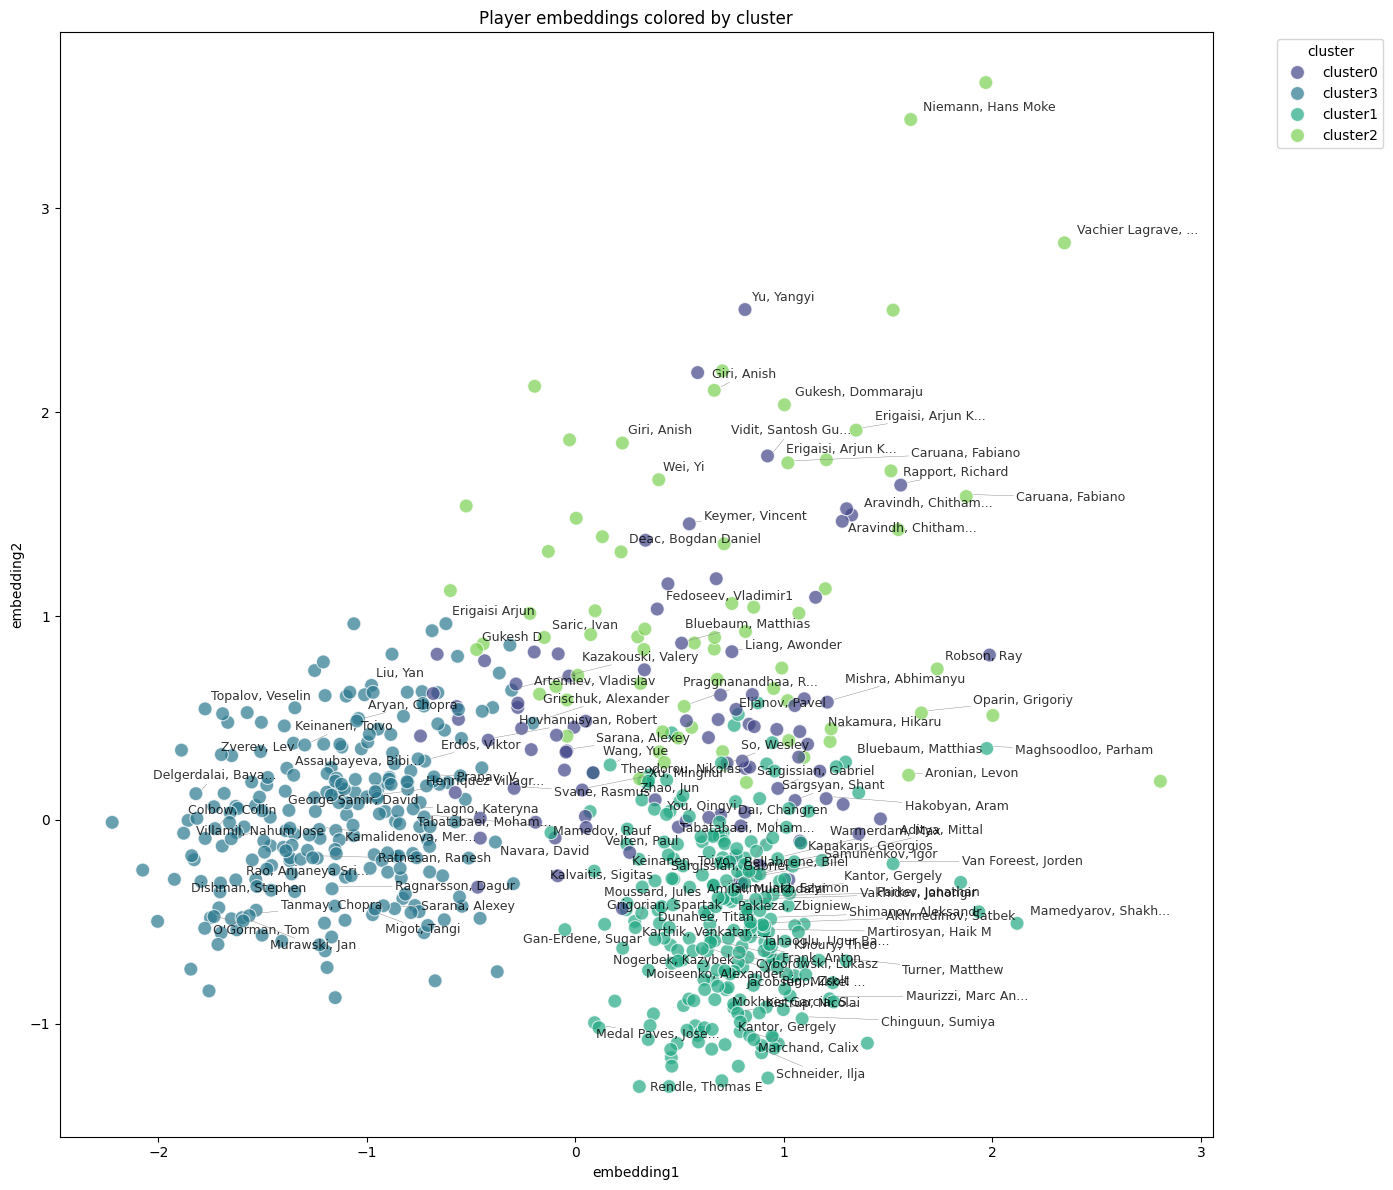

In [40]:
plot_clusters(hue="cluster")


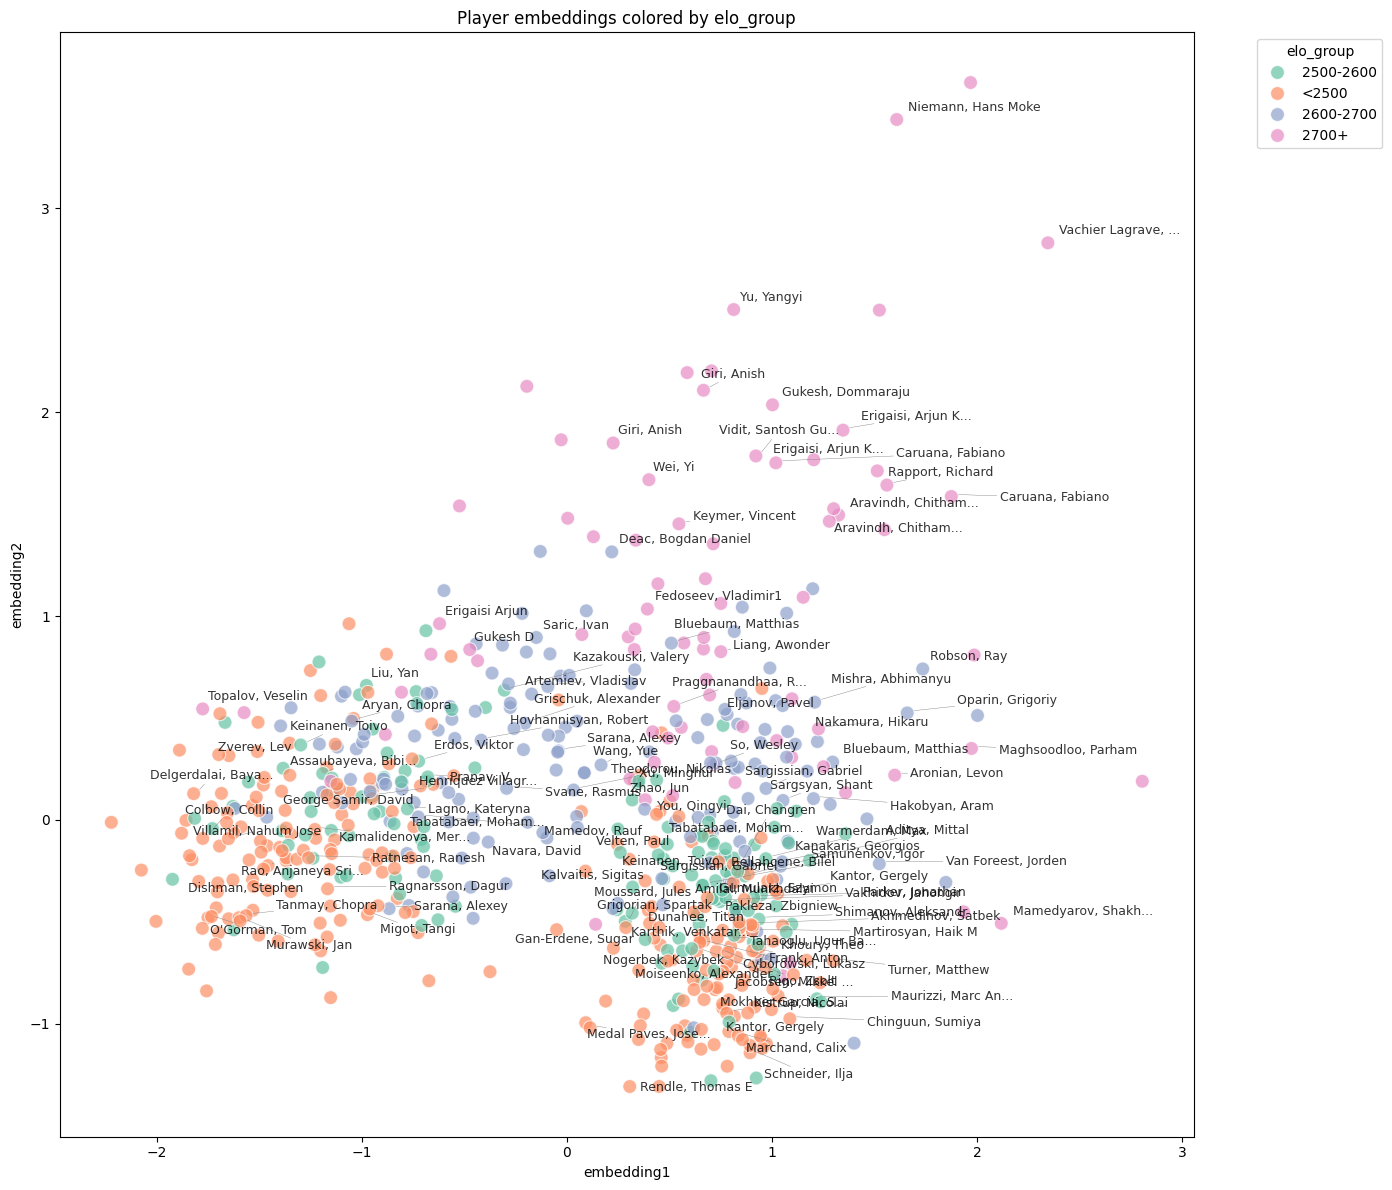

In [41]:
plot_clusters(hue="elo_group")


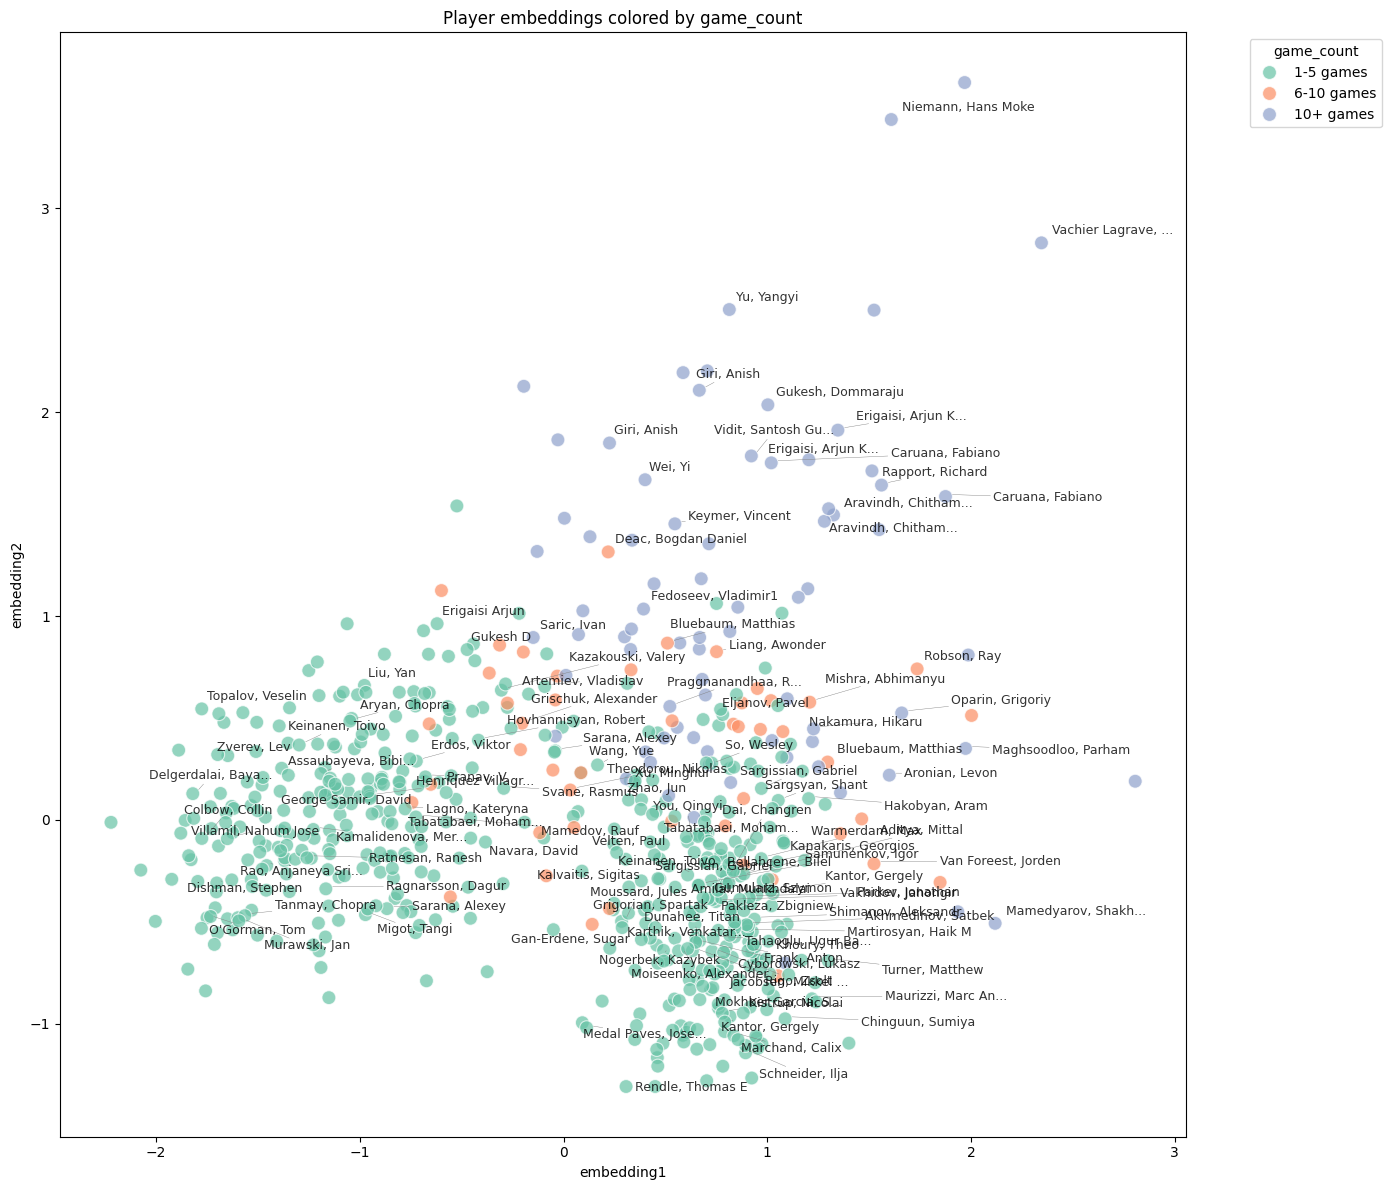

In [42]:
plot_clusters(hue="game_count")

In [43]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.elo_group, plot_df.cluster)

0.1691245943713085

In [44]:
metrics.adjusted_rand_score(plot_df.game_count, plot_df.cluster)

0.21400533628208485

In [45]:
def convert_chess_result(result_str):
    if result_str == "1-0":
        return 0
    elif result_str == "0-1":
        return 1
    else:
        return 2

In [46]:
df["results"] = df["result"].apply(convert_chess_result)
df.results.value_counts(normalize=True)

results
2    0.406963
0    0.342537
1    0.250500
Name: proportion, dtype: float64

In [54]:
new_df = df[["results", "train"]].copy()
new_df["year"] = df["date"].apply(lambda x: int(x[:4]))
new_df["month"] = df["date"].apply(lambda x: int(x[5:7]))
new_df["day"] = df["date"].apply(lambda x: int(x[8:10]))
new_df["white_elo"] = pd.to_numeric(df["white_elo"], errors='coerce')
new_df["black_elo"] = pd.to_numeric(df["black_elo"], errors='coerce')
new_df["moves"] = pd.to_numeric(df["moves"], errors='coerce')
new_df["elo_difference"] = new_df["white_elo"] - new_df["black_elo"]
categorical_cols = ["site", "eco"]
encoded_cols = pd.get_dummies(df[categorical_cols], prefix=categorical_cols, drop_first=True)
player_cols = ["white_player", "black_player"]
min_games = 5
all_players = pd.concat([df["white_player"], df["black_player"]])
player_counts = all_players.value_counts()
top_players = player_counts[player_counts >= min_games].index
for player in top_players[:20]:
    new_df[f"white_is_{player.replace(', ', '_').replace(' ', '_')[:20]}"] = (df["white_player"] == player).astype(int)
    new_df[f"black_is_{player.replace(', ', '_').replace(' ', '_')[:20]}"] = (df["black_player"] == player).astype(int)
new_df = pd.concat([new_df, encoded_cols], axis=1)
new_df = new_df.fillna(0)


In [56]:
new_df.shape


(2499, 394)

In [57]:
new_df.head()

,results,train,year,month,day,white_elo,black_elo,moves,elo_difference,white_is_Abdusattorov_Nodirbe,...,eco_E70,eco_E71,eco_E73,eco_E81,eco_E82,eco_E90,eco_E91,eco_E92,eco_E94,eco_E97
0,1,False,2025,12,23,2749,2599.0,44,150.0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,False,2025,12,23,2628,2732.0,49,-104.0,0,...,False,False,False,False,False,False,False,False,False,False
2,1,False,2025,12,23,2599,2749.0,90,-150.0,0,...,False,False,False,False,False,False,False,False,False,False
3,2,False,2025,12,23,2732,2628.0,61,104.0,0,...,False,False,False,False,False,False,False,False,False,False
4,2,False,2025,12,23,2692,2727.0,64,-35.0,0,...,False,False,False,False,False,False,False,False,False,False


In [58]:
from xgboost import XGBClassifier
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")
X_train = new_df[df["train"]].drop(["results"], axis=1)
y_train = new_df[df["train"]].results
X_val = new_df[~df["train"]].drop(["results"], axis=1)
y_val = new_df[~df["train"]].results
clf_model.fit(X_train, y_train, verbose=1)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [59]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.5155642023346303

In [61]:
def get_features_target(mask):
    def get_player_embedding(player_id):
        return player_embeddings.get(player_id, np.full(200, np.nan))
    white_embeddings = df[mask].white_player_id.apply(get_player_embedding).values
    black_embeddings = df[mask].black_player_id.apply(get_player_embedding).values
    white_embeddings_stacked = np.vstack(white_embeddings)
    black_embeddings_stacked = np.vstack(black_embeddings)
    X = np.hstack((white_embeddings_stacked, black_embeddings_stacked))
    y = df[mask].results.values
    return X, y
clf_X_train, y_train = get_features_target(df["train"])
clf_X_test, y_test = get_features_target(~df["train"])
clf_X_train.shape, clf_X_test.shape

((1985, 400), (514, 400))

In [62]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

74.5

In [63]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")
clf_model.fit(clf_X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [64]:
df[~df["train"]].results.value_counts(normalize=True)

results
2    0.457198
0    0.299611
1    0.243191
Name: proportion, dtype: float64

In [65]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.40077821011673154

In [66]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=1000)
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
matchSubject = "Match10581426"
print(df[df.subject==matchSubject])

             subject   predicate         object
1779   Match10581426   hasFormat        Format1
4223   Match10581426      heldAt    EventRhodes
4300   Match10581426   hasResult  Result1/2-1/2
12398  Match10581426    hasMoves             93
16767  Match10581426  hasOpening     OpeningB30
22351  Match10581426    playedOn     2025-10-25


In [67]:
dfFiltered = np.array(df[(df.subject != matchSubject) | 
                         ((df.subject == matchSubject) & 
                          ~df.predicate.isin(["hasResult"]))])
model.fit(dfFiltered)
statements = np.array([
    [f'{matchSubject}', 'hasResult', 'Result1-0'],
    [f'{matchSubject}', 'hasResult', 'Result0-1'],
    [f'{matchSubject}', 'hasResult', 'Result1/2-1/2']
])
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

Epoch 1/100
24/24 [==============================] - 1s 44ms/step - loss: 348.7965
Epoch 2/100
24/24 [==============================] - 1s 43ms/step - loss: 348.4833
Epoch 3/100
24/24 [==============================] - 1s 42ms/step - loss: 348.1726
Epoch 4/100
24/24 [==============================] - 1s 42ms/step - loss: 347.8574
Epoch 5/100
24/24 [==============================] - 1s 42ms/step - loss: 347.5501
Epoch 6/100
24/24 [==============================] - 1s 41ms/step - loss: 347.2402
Epoch 7/100
24/24 [==============================] - 1s 41ms/step - loss: 346.9290
Epoch 8/100
24/24 [==============================] - 1s 41ms/step - loss: 346.6197
Epoch 9/100
24/24 [==============================] - 1s 41ms/step - loss: 346.3102
Epoch 10/100
24/24 [==============================] - 1s 42ms/step - loss: 346.0007
Epoch 11/100
24/24 [==============================] - 1s 42ms/step - loss: 345.6955
Epoch 12/100
24/24 [==============================] - 1s 42ms/step - loss: 345.3907
E

In [68]:
scores = model.predict(statements)
scores


array([0.8972684 , 0.10893709, 5.2139645 ], dtype=float32)

In [69]:
from scipy.special import expit
probs = expit(scores)
results_df = pd.DataFrame(list(zip([' '.join(x) for x in statements],
                                   ranks,
                                   np.squeeze(scores),
                                   np.squeeze(probs))),
                         columns=['statement', 'rank', 'score', 'prob']).sort_values("prob", ascending=False)
results_df


,statement,rank,score,prob
2,Match10581426 hasResult Result1/2-1/2,"[639, 1]",5.213964,0.994589
0,Match10581426 hasResult Result1-0,"[1302, 126]",0.897268,0.710388
1,Match10581426 hasResult Result0-1,"[1599, 1172]",0.108937,0.527207


In [70]:
actual_result = df[(df.subject == matchSubject) & (df.predicate == "hasResult")]
if not actual_result.empty:
    print(f"\nActual result: {actual_result.iloc[0]['object']}")


Actual result: Result1/2-1/2
